In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.datasets import GoodSoundsDataset
from torch.utils.data import DataLoader

dataset = GoodSoundsDataset(root_dir="../good_sounds_dataset",
                            db_filename="good-sounds/database.sqlite")

device = "cuda"

from src.model import ALMTokenizer
expansion_factor = 4

encoder_args = {"embed_dim": 128, "n_heads": 8, "n_layers": 6, "dim_feedforward": 128*expansion_factor}
decoder_args = {"embed_dim": 128, "n_heads": 8, "n_layers": 6, "dim_feedforward": 128*expansion_factor}

mae_decoder_args = {"embed_dim": 128, "n_heads": 4, "n_layers": 4, "dim_feedforward": 128*expansion_factor}
mae_encoder_args = {"embed_dim": 128, "n_heads": 4, "n_layers": 4, "dim_feedforward": 128*expansion_factor}

patchify_args = {"device": device}
unpatchify_args = {"device": device}

model = ALMTokenizer(
    from_raw_audio=True,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    mae_decoder_args=mae_decoder_args,
    patchify_args=patchify_args,
    unpatchify_args=unpatchify_args,
    window_size=6,
).to(device)

for p in model.patchify.parameters: p.requires_grad = False
for p in model.unpatchify.parameters: p.requires_grad = False

model.load_model("checkpoints/alm_tokenizer_4_lr_d1.00e-08_lr_g1.00e-04/alm_tokenizer_epoch_330.pth")
print(model)

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


ALMTokenizer(
  (query_encoder): QueryEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (pos_encoder): PositionalEncoding()
  )
  (query_decoder): QueryEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): M

### Generate the embeddings

In [133]:
from encodec import EncodecModel
import h5py
import torch
from tqdm import trange

def save_codes_h5(
    dataset,
    model,
    h5_path: str,
    device: str = 'cpu'
) -> None:
    """
    Encode each waveform with Encodec and save codes and metadata to an HDF5 file.

    Args:
        dataset (Dataset): GoodSoundsDataset instance.
        h5_path (str): Path to output .h5 file.
        device (str): torch device for model (e.g. 'cpu' or 'cuda').
    """
    # Load Encodec encoder
    encodec = EncodecModel.encodec_model_24khz().to(device)
    encoder = encodec.encoder

    with h5py.File(h5_path, 'w') as h5f:
        for idx in trange(len(dataset)):
            sample = dataset[idx]
            wav = sample['waveform'].unsqueeze(0).to(device)
            
            # Create a group for this sample
            grp_name = f"sound_{sample['sound_id']}_take_{sample['take_id']}"
            grp = h5f.create_group(grp_name)

            # Save metadata as attributes
            for key in ['sound_id', 'take_id', 'instrument', 'note', 'octave', 'dynamics', 'sustain', 'release', 'klass']:
                value = sample.get(key, None)
                # None -> empty string
                if value is None:
                    value = ''
                # Cast numeric types to int
                elif isinstance(value, torch.Tensor):
                    value = value.item()
                # Ensure all values are native Python types
                elif isinstance(value, (bytes, bytearray)):
                    value = value.decode('utf-8')
                else:
                    value = str(value)
                grp.attrs.create(key, value)


            if sample.get("sustain", "null") != "null" and sample.get("release", "null") != "null":
                wav = wav[:, sample['sustain']:sample['release']]

            with torch.no_grad():
                # Codes: list of [B, L] tensors for each codebook
                z_codes = encoder(wav)
                # Save each code tensor as a dataset
                for level, c in enumerate(z_codes):
                    # Remove batch dim
                    arr = c.squeeze(0).cpu().detach().numpy()
                    grp.create_dataset(f"z_level_{level}", data=arr, compression='gzip')

                h_codes = model.encode(wav)

                # Save each code tensor as a dataset
                for level, c in enumerate(h_codes):
                    # Remove batch dim
                    arr = c.squeeze(0).cpu().detach().numpy()
                    grp.create_dataset(f"h_level_{level}", data=arr, compression='gzip')

    print(f"Saved codes and metadata for {len(dataset)} samples to {h5_path}")

save_codes_h5(
    dataset=dataset,
    model=model.eval(),
    h5_path="codes/good_sounds.h5",
    device="cuda"
)

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
100%|██████████| 16308/16308 [20:55<00:00, 12.99it/s]


Saved codes and metadata for 16308 samples to codes/good_sounds.h5


### Structure the data

In [3]:
import h5py

z = list()
z_attrs = list()

h = list()
h_attrs = list()

with h5py.File("codes/good_sounds.h5", 'r') as f:
    # Get the mean of each sample's codes
    for i, key in enumerate(f.keys()):
        grp = f[key]

        keys = ["sound_id", "instrument", "note", "octave", "klass"]
        res_dict = dict()
        for key in keys:
            res_dict[key] = grp.attrs.get(key, "unknown")

        z_mat = grp["z_level_0"][:]
        z_attrs += [res_dict] * z_mat.shape[1]
        z.append(z_mat)

        h_mat = grp["h_level_0"][:]
        h_attrs += [res_dict] * h_mat.shape[0]
        h.append(h_mat)

In [4]:
import numpy as np
z_res = np.hstack(z).T
h_res = np.vstack(h)

In [5]:
import gc
del z
del h
gc.collect()

87

In [6]:
import pandas as pd

z_attributes = pd.DataFrame(z_attrs)
h_attributes = pd.DataFrame(h_attrs)

### Define the labels

In [7]:
# Transform labels to integer indices
from sklearn.preprocessing import LabelEncoder

z_label_encoders = {
    'instrument': LabelEncoder(),
    'note': LabelEncoder(),
    'octave': LabelEncoder(),
    'klass': LabelEncoder()
}

z_num_labels = pd.DataFrame(columns=z_label_encoders.keys())


for key in z_label_encoders:
    print(key)
    le = z_label_encoders[key]
    le.fit(z_attributes[key])
    print(le.classes_)
    z_num_labels[key] = le.transform(z_attributes[key])
    print(z_num_labels[key].unique())

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


instrument
['bass' 'cello' 'clarinet' 'flute' 'oboe' 'piccolo' 'sax_alto'
 'sax_baritone' 'sax_soprano' 'sax_tenor' 'trumpet' 'violin']
[ 2  3 10 11  1  6  9  7  8  4  5  0]
note
['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']
[ 4  5  6  7  8  9 10 11  0  1  2  3]
octave
['1' '2' '3' '4' '5' '6' '7']
[4 3 5 2 6 1 0]
klass
['' ' good-sound-pizzicato-hard' ' good-sound-pizzicato-soft' 'air-inside'
 'air-outside' 'bad-air' 'bad-attack' 'bad-attack bad-richness'
 'bad-attack bad-richness bad-timbre' 'bad-attack bad-timbre bad-richness'
 'bad-attack-air' 'bad-attack-gallo' 'bad-attack-multiphonic'
 'bad-attack-pitch-down' 'bad-attack-pitch-up' 'bad-attack-pressure'
 'bad-attack-rebond' 'bad-attack-tongue' 'bad-attack-tongue-block'
 'bad-attack-too-strong' 'bad-dynamic-stability' 'bad-dynamics'
 'bad-dynamics bad-timbre' 'bad-dynamics-bad-timbre-bad-pitch'
 'bad-dynamics-crescendo' 'bad-dynamics-decrescendo' 'bad-dynamics-errors'
 'bad-dynamics-stability-crescendo' 'bad-dynamics-stabi

In [8]:
# Transform labels to integer indices
from sklearn.preprocessing import LabelEncoder

h_label_encoders = {
    'instrument': LabelEncoder(),
    'note': LabelEncoder(),
    'octave': LabelEncoder(),
    'klass': LabelEncoder()
}

h_num_labels = pd.DataFrame(columns=h_label_encoders.keys())


for key in h_label_encoders:
    le = h_label_encoders[key]
    le.fit(z_attributes[key])
    h_num_labels[key] = le.transform(h_attributes[key])

instrumentle = LabelEncoder()
instrument_labels = le.fit_transform(h_attributes['instrument'])

In [31]:
z_label_encoders["klass"].classes_

array(['', ' good-sound-pizzicato-hard', ' good-sound-pizzicato-soft',
       'air-inside', 'air-outside', 'bad-air', 'bad-attack',
       'bad-attack bad-richness', 'bad-attack bad-richness bad-timbre',
       'bad-attack bad-timbre bad-richness', 'bad-attack-air',
       'bad-attack-gallo', 'bad-attack-multiphonic',
       'bad-attack-pitch-down', 'bad-attack-pitch-up',
       'bad-attack-pressure', 'bad-attack-rebond', 'bad-attack-tongue',
       'bad-attack-tongue-block', 'bad-attack-too-strong',
       'bad-dynamic-stability', 'bad-dynamics', 'bad-dynamics bad-timbre',
       'bad-dynamics-bad-timbre-bad-pitch', 'bad-dynamics-crescendo',
       'bad-dynamics-decrescendo', 'bad-dynamics-errors',
       'bad-dynamics-stability-crescendo',
       'bad-dynamics-stability-decrescendo',
       'bad-dynamics-stability-errors', 'bad-dynamics-stability-tremolo',
       'bad-dynamics-tremolo', 'bad-pitch',
       'bad-pitch bad-dynamics bad-timbre', 'bad-pitch bad-timbre',
       'bad-pitch

In [32]:
z_label_encoders["klass"].transform([" good-sound-pizzicato-hard"])

array([1])

In [10]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
from matplotlib import cm

tsne = TSNE(n_jobs=-1)

# Random subsample indices for faster computation
n_samples = 10000
z_indices = np.random.choice(z_res.shape[0], n_samples, replace=False)


In [ ]:

z_coords = tsne.fit_transform(z_res[z_indices])


/tmp/ipykernel_441617/1213717146.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


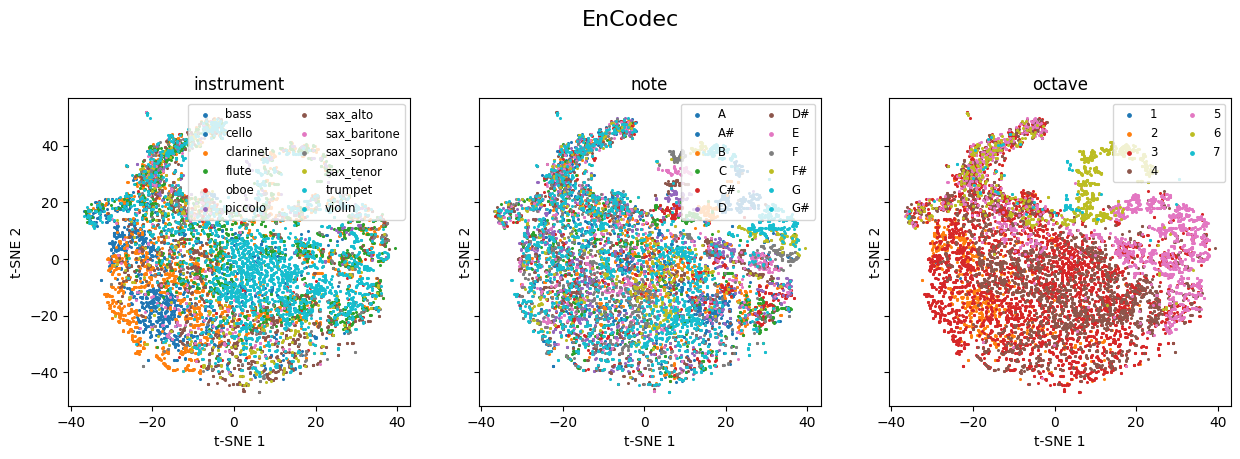

In [60]:

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs = axs.flatten()


for ax, key in zip(axs, ["instrument", "note", "octave"]):
    colors = cm.get_cmap("tab10", len(z_label_encoders[key].classes_))
    for label, c in zip(z_label_encoders[key].classes_, colors.colors.tolist()):
        # Get coordinates for the current label
        grp_coords = z_coords[z_attributes[key][z_indices] == label]
        ax.scatter(grp_coords[:, 0], grp_coords[:, 1], color=c, s=1.5, cmap="tab10", label=label)
    ax.set_title(key)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(loc='upper right', fontsize='small', markerscale=2, ncol=2)

fig.suptitle("EnCodec", fontsize=16, y=1.1)

fig.show()


In [11]:
tsne = TSNE(n_jobs=-1)

# Random subsample indices for faster computation
n_samples = 10000
h_indices = np.random.choice(h_res.shape[0], n_samples, replace=False)


In [ ]:

h_coords = tsne.fit_transform(h_res[h_indices])


/tmp/ipykernel_441617/1173416131.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


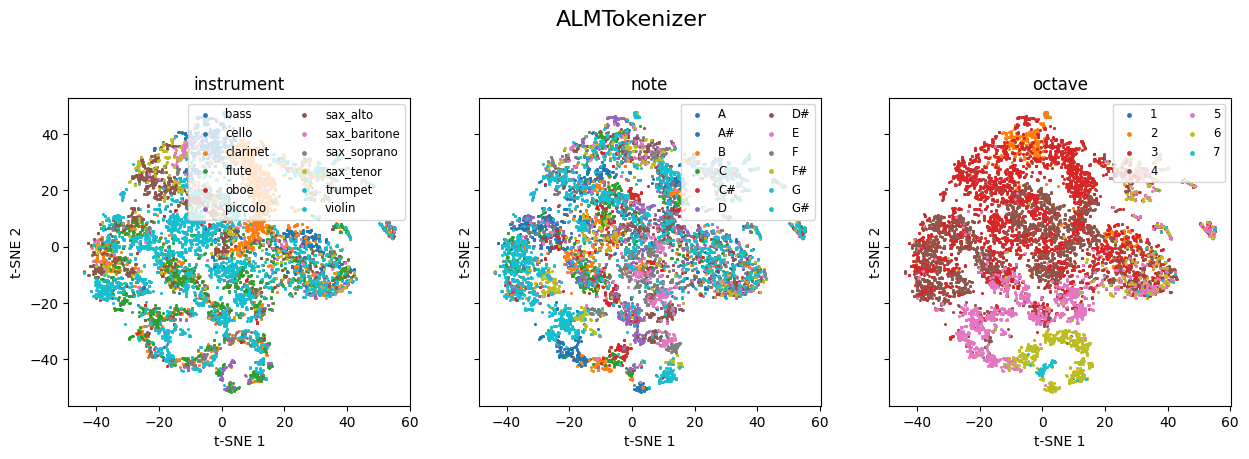

In [61]:

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs = axs.flatten()


for ax, key in zip(axs, ["instrument", "note", "octave"]):
    colors = cm.get_cmap("tab10", len(h_label_encoders[key].classes_))
    for label, c in zip(h_label_encoders[key].classes_, colors.colors.tolist()):
        # Get coordinates for the current label
        grp_coords = h_coords[h_attributes[key][h_indices] == label]
        ax.scatter(grp_coords[:, 0], grp_coords[:, 1], color=c, s=1.5, cmap="tab10", label=label)
    ax.set_title(key)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(loc='upper right', fontsize='small', markerscale=2, ncol=2)

fig.suptitle("ALMTokenizer", fontsize=16, y=1.1)

fig.show()


  0%|          | 0/4 [00:00<?, ?it/s]

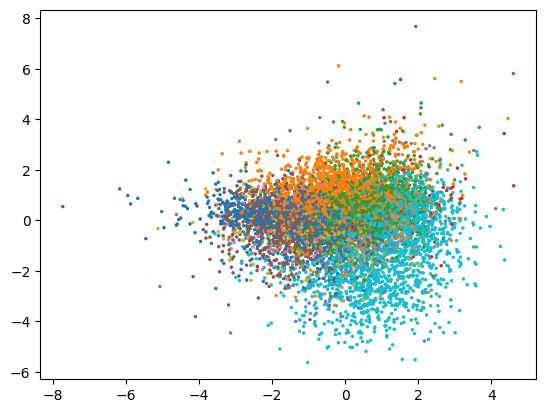

 25%|██▌       | 1/4 [00:00<00:01,  1.71it/s]

Cummulative Explained Variance:  [0.26187432 0.46394086 0.62683828 0.76502135 0.85719976 0.90193222
 0.94076386 0.96813105 0.98328131 0.99499041 1.        ]


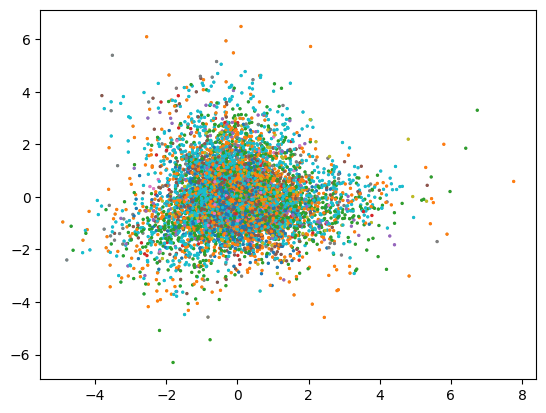

 50%|█████     | 2/4 [00:01<00:01,  1.77it/s]

Cummulative Explained Variance:  [0.16110534 0.31475929 0.46555407 0.58904372 0.70739275 0.80805489
 0.87109233 0.91902328 0.95326527 0.98110735 1.        ]


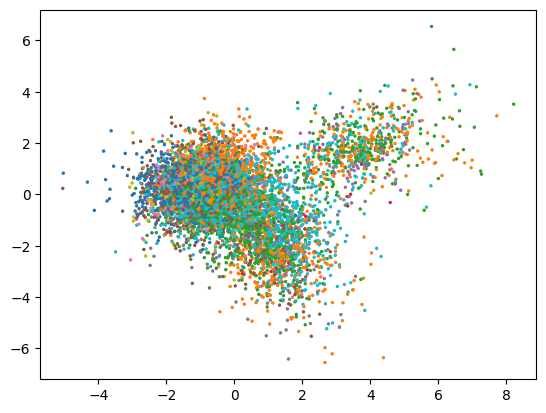

 75%|███████▌  | 3/4 [00:01<00:00,  1.85it/s]

Cummulative Explained Variance:  [0.50076765 0.72200371 0.87091084 0.94903229 0.99597839 1.        ]


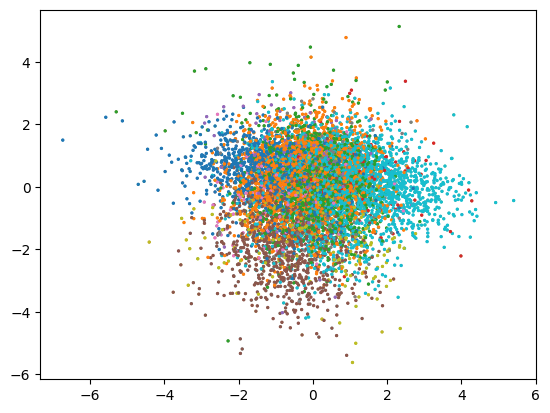

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

Cummulative Explained Variance:  [0.1022583  0.1959128  0.27484541 0.34155063 0.38189143 0.41780568
 0.4456761  0.47029843 0.4941334  0.51433349 0.53243659 0.54941943
 0.56603874 0.58151341 0.59597409 0.609917   0.62288016 0.63541366
 0.64726882 0.65876803 0.66984492 0.68090555 0.6912458  0.70132371
 0.71112005 0.72068912 0.72992468 0.73884396 0.74735849 0.75571083
 0.76390163 0.77170399 0.77943414 0.78692812 0.79398578 0.80086809
 0.80758233 0.81415699 0.82061216 0.82690654 0.83300019 0.8389589
 0.84471931 0.8503563  0.85586117 0.86118856 0.86630423 0.87134276
 0.87623868 0.88107364 0.88554117 0.88995738 0.89427965 0.89852226
 0.90272108 0.90669911 0.91060008 0.91441515 0.91810779 0.92161125
 0.92499003 0.92832058 0.93159157 0.93479313 0.93792043 0.94089561
 0.94366682 0.94624483 0.94880459 0.9512028  0.95353313 0.95577169
 0.95797203 0.96009557 0.96214625 0.9641058  0.96603835 0.96791038
 0.96968474 0.97139813 0.97304323 0.97465806 0.97612412 0.97755105
 0.97894891 0.9802946  0.98160

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


from tqdm import tqdm
for key in tqdm(z_num_labels.columns):
    lda = LDA()
    coords_lda = lda.fit_transform(z_res[z_indices], z_num_labels[key][z_indices])
    plt.scatter(coords_lda[:, 0], coords_lda[:, 1], c=z_num_labels[key][z_indices], s=1, cmap="tab10")


    plt.scatter(coords_lda[:, 0], coords_lda[:, 1], c=z_num_labels["instrument"][z_indices], s=2, cmap="tab10")
    ax.set_xlabel('LDA Component 1')
    ax.set_ylabel('LDA Component 2')
    plt.show()

    print("Cummulative Explained Variance: ", np.cumsum(lda.explained_variance_ratio_))

  0%|          | 0/4 [00:00<?, ?it/s]

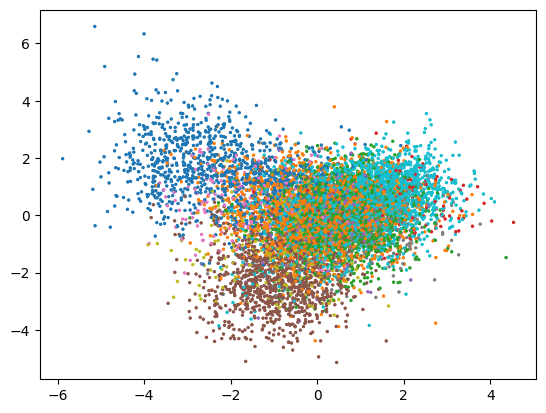

 25%|██▌       | 1/4 [00:00<00:02,  1.10it/s]

Cummulative Explained Variance:  [0.25974729 0.46512177 0.62868636 0.75248953 0.84532308 0.89551972
 0.93254716 0.95933418 0.977657   0.98955754 1.        ]


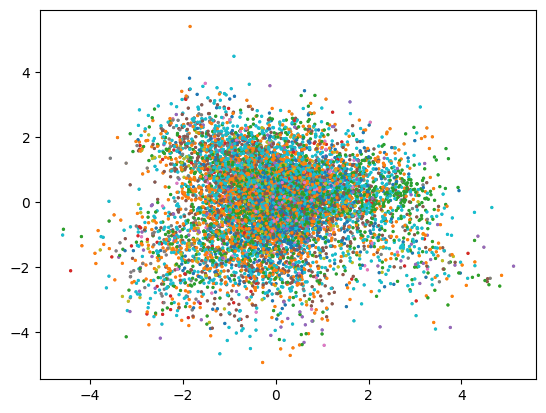

 50%|█████     | 2/4 [00:01<00:01,  1.54it/s]

Cummulative Explained Variance:  [0.17969202 0.34462981 0.48444756 0.60912424 0.72201495 0.83330735
 0.88136012 0.92624089 0.95907322 0.98376879 1.        ]


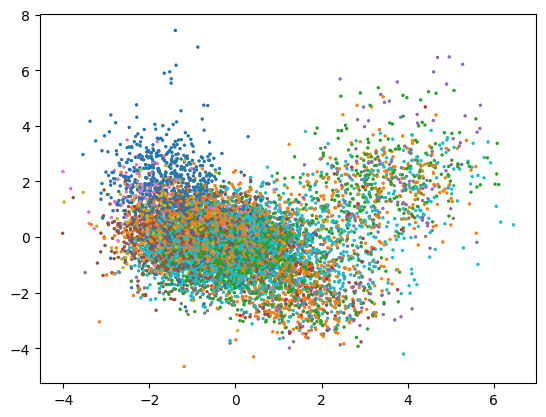

 75%|███████▌  | 3/4 [00:01<00:00,  1.70it/s]

Cummulative Explained Variance:  [0.45641796 0.65799234 0.81327741 0.91338601 0.99117019 1.        ]


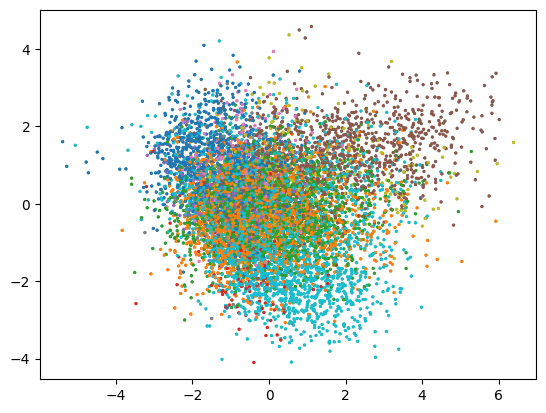

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

Cummulative Explained Variance:  [0.1999201  0.28870899 0.36150145 0.41880024 0.46225771 0.49833431
 0.52988455 0.55804665 0.58095188 0.60329173 0.62293496 0.63947393
 0.65298463 0.66618155 0.67882495 0.69027445 0.70148972 0.71248977
 0.72247521 0.73201974 0.74101778 0.74986672 0.75856606 0.76694504
 0.77477337 0.78232273 0.78976767 0.7969419  0.80373544 0.81027874
 0.81668941 0.82289697 0.82892845 0.83483978 0.84046846 0.8460478
 0.85156001 0.85701016 0.86220755 0.86714205 0.87195263 0.87663196
 0.88116862 0.8856656  0.8899992  0.89418462 0.89818091 0.90204735
 0.9057896  0.90946622 0.91297793 0.91645123 0.91979328 0.92294403
 0.92604849 0.92900025 0.93190381 0.93465595 0.93733346 0.93996635
 0.94244405 0.94486533 0.94719823 0.94948832 0.95174566 0.95392288
 0.95603372 0.95806472 0.96004377 0.96188926 0.96365809 0.96542569
 0.96715302 0.96882178 0.97043077 0.97201703 0.9735122  0.97493879
 0.97631851 0.97759828 0.97886028 0.98008829 0.98126532 0.98240917
 0.98349756 0.98456797 0.98560

In [40]:
for key in tqdm(h_num_labels.columns):
    lda = LDA()
    coords_lda = lda.fit_transform(h_res[h_indices], h_num_labels[key][h_indices])
    plt.scatter(coords_lda[:, 0], coords_lda[:, 1], c=h_num_labels[key][h_indices], s=1, cmap="tab10")


    plt.scatter(coords_lda[:, 0], coords_lda[:, 1], c=h_num_labels["instrument"][h_indices], s=2, cmap="tab10")
    ax.set_xlabel('LDA Component 1')
    ax.set_ylabel('LDA Component 2')
    plt.show()

    print("Cummulative Explained Variance: ", np.cumsum(lda.explained_variance_ratio_))

# Clustering

In [78]:
from sklearn.cluster import KMeans

n_clusters = np.unique(instrument_labels).size

z_kmeans = KMeans(n_clusters=9, random_state=0)

z_clusters = z_kmeans.fit_predict(z_res)

plt.scatter(z_coords[:, 0], z_coords[:, 1], c=z_clusters, cmap="tab10", s=1)

KeyboardInterrupt: 

# Linear Separability Tests

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

for key in z_label_encoders.keys():
    X_train, X_test, y_train, y_test = train_test_split(z_res[z_indices], z_num_labels[key][z_indices], test_size=0.2, random_state=42, stratify=z_num_labels[key][z_indices])
    svm = SVC(kernel='linear', C=1e6, random_state=42)
    svm.fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test)
    print(f"SVM accuracy for {key}: {accuracy:.2f}")

SVM accuracy for instrument: 0.57


In [ ]:
for key in h_label_encoders.keys():
    X_train, X_test, y_train, y_test = train_test_split(h_res[h_indices], h_num_labels[key][h_indices], test_size=0.2, random_state=42, stratify=h_num_labels[key][h_indices])
    svm = SVC(kernel='linear', C=1.0, random_state=42)
    svm.fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test)
    print(f"SVM accuracy for {key}: {accuracy:.2f}")

SVM accuracy for instrument: 0.67
SVM accuracy for note: 0.48
SVM accuracy for octave: 0.76


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

# Interpolation test

In [119]:
np.unique(instrument)

array(['bass', 'cello', 'clarinet', 'flute', 'piccolo', 'sax_alto',
       'sax_baritone', 'sax_soprano', 'trumpet', 'violin'], dtype='<U12')

In [53]:
instrument1 = "flute"
instrument2 = "flute"

In [55]:
print(h_attributes[(h_attributes.instrument==instrument1) & (h_attributes.octave == "4")].apply(lambda x: np.unique(x)))
print(h_attributes[(h_attributes.instrument==instrument2) & (h_attributes.octave == "4")].apply(lambda x: np.unique(x)))


sound_id      [1, 10, 100, 101, 102, 103, 11, 12, 13, 14, 15...
instrument                                              [flute]
note                  [A, A#, B, C, C#, D, D#, E, F, F#, G, G#]
octave                                                      [4]
klass                      [bad-stability-dynamics, good-sound]
dtype: object
sound_id      [1, 10, 100, 101, 102, 103, 11, 12, 13, 14, 15...
instrument                                              [flute]
note                  [A, A#, B, C, C#, D, D#, E, F, F#, G, G#]
octave                                                      [4]
klass                      [bad-stability-dynamics, good-sound]
dtype: object


In [63]:
len(h_res)

88772

In [109]:
import torch

z1 = torch.tensor(z_res[(z_attributes["instrument"] == instrument1) & (z_attributes["note"] == "C") & (z_attributes["octave"] == "4"), :].mean(axis=0)).unsqueeze(0).unsqueeze(0)
z2 = torch.tensor(z_res[(z_attributes["instrument"] == instrument2) & (z_attributes["note"] == "B") & (z_attributes["octave"] == "4"), :].mean(axis=0)).unsqueeze(0).unsqueeze(0)

h1 = torch.tensor(h_res[(h_attributes["instrument"] == instrument1) & (h_attributes["note"] == "C") & (h_attributes["octave"] == "4"), :].mean(axis=0)).unsqueeze(0).unsqueeze(0)
h2 = torch.tensor(h_res[(h_attributes["instrument"] == instrument2) & (h_attributes["note"] == "B") & (h_attributes["octave"] == "4"), :].mean(axis=0)).unsqueeze(0).unsqueeze(0)

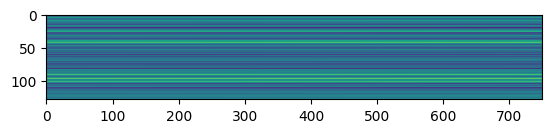

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


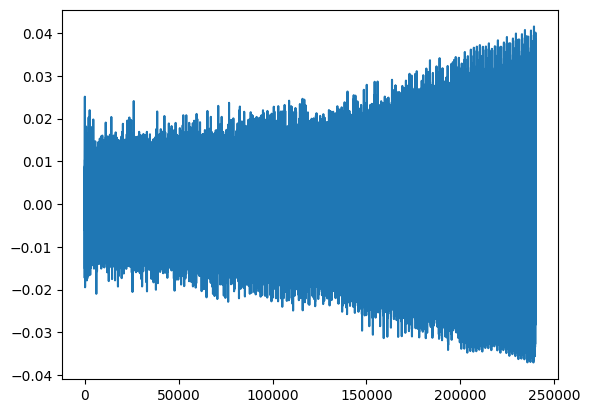

In [110]:
import numpy as np
def interpolate_latent(h1, h2, n):
    """
    Linearly interpolate n steps between vectors h1 and h2.

    Args:
        h1 (array-like, shape (D,)): Start latent vector.
        h2 (array-like, shape (D,)): End latent vector.
        n (int): Number of interpolation points (including h1 and h2).

    Returns:
        np.ndarray of shape (n, D): Interpolated vectors.
    """
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    # 1. Create n weights from 0.0 to 1.0
    alphas = np.linspace(0.0, 1.0, num=n)  
    # 2. Compute each interpolation: (1-α)*h1 + α*h2
    return np.array([(1.0 - a) * h1 + a * h2 for a in alphas]).squeeze(1)

device = "cpu"
# Interpolate between two latent representations, not using the model
interp = interpolate_latent(z1, z2, 750)
interp = torch.tensor(interp, dtype=torch.float32).to(device)
interp = interp.permute(1, 2, 0)

import matplotlib.pyplot as plt
plt.imshow(interp[0])
plt.show()

from encodec import EncodecModel
z_dec = EncodecModel.encodec_model_24khz().decoder.to(device)
wav = z_dec(interp).squeeze(1)

plt.plot(wav[0].detach().numpy())

import IPython.display as ipd
ipd.display(ipd.Audio(wav[0].detach().cpu().numpy(), rate=24000))

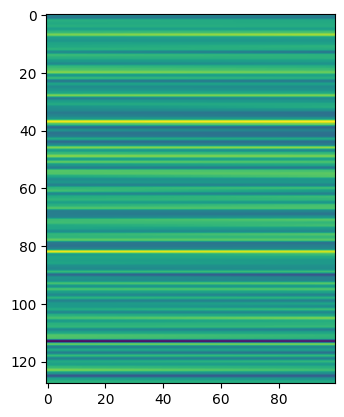

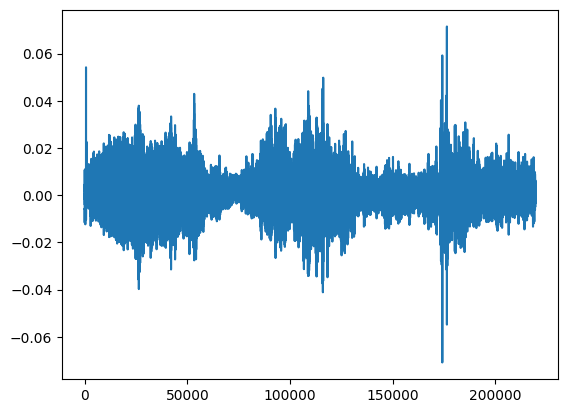

In [111]:
device = "cpu"
# Interpolate between two latent representations, not using the model
interp = interpolate_latent(h1, h2, 100)
interp = torch.tensor(interp, dtype=torch.float32).to(device)
interp = interp.permute(1, 2, 0)

import matplotlib.pyplot as plt
plt.imshow(interp[0])
plt.show()

wav = model.decode(interp.transpose(1, 2)).squeeze(1)

plt.plot(wav[0].detach().numpy())

import IPython.display as ipd
ipd.display(ipd.Audio(wav[0].detach().cpu().numpy(), rate=24000))

In [ ]:
model.decode(torch.randn(1, 75, 128).to(device))

tensor([[[-0.0783, -0.0825, -0.0669,  ..., -0.1477, -0.1603, -0.1673]]],
       device='cuda:0')

In [ ]:
input = torch.tensor(h_res[:100]).unsqueeze(0).to(device)
wav = model.decode(input)
import IPython.display as ipd
ipd.display(ipd.Audio(wav[0].cpu().numpy(), rate=24000))